In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from category_encoders import MEstimateEncoder

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error,r2_score,root_mean_squared_error

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [80]:
df = pd.read_csv('Houses_Data.csv')
print(df.shape)
df.tail()

(4600, 18)


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4595,2014-07-09 00:00:00,308166.666667,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,501 N 143rd St,Seattle,WA 98133,USA
4596,2014-07-09 00:00:00,534333.333333,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,14855 SE 10th Pl,Bellevue,WA 98007,USA
4597,2014-07-09 00:00:00,416904.166667,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,759 Ilwaco Pl NE,Renton,WA 98059,USA
4598,2014-07-10 00:00:00,203400.000000,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,5148 S Creston St,Seattle,WA 98178,USA
4599,2014-07-10 00:00:00,220600.000000,3.0,2.50,1490,8102,2.0,0,0,4,1490,0,1990,0,18717 SE 258th St,Covington,WA 98042,USA


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [82]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [83]:
df['country'].unique()

array(['USA'], dtype=object)

##### We can drop the 'country' column as it contains only single unique value which is 'USA'.

In [84]:
df.drop(columns=['country'],axis=1,inplace= True)

## Analyzing price column

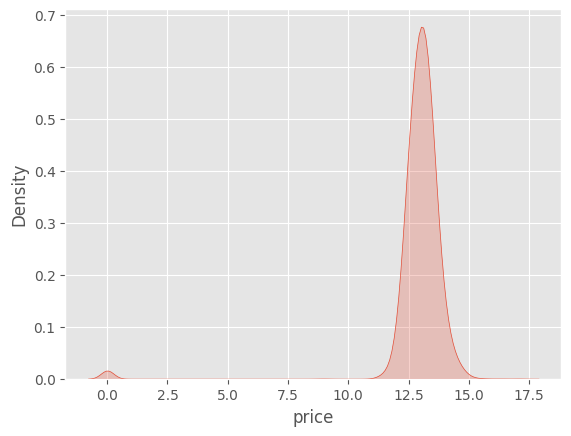

In [85]:
sns.kdeplot(df['price'].apply(np.log1p), fill=True)
plt.show()

- Plot is **left-skewed**, which means there are outliers.
- **Outliers** can either be a mistake or just **variance**. To address the outliers we have plenty of methods available.
- Here we will use **z-score**.

In [86]:
def make_mi_score(x,y):
    x = x.copy()
    for colname in x.select_dtypes(['object','category']):
        x[colname], _ = x[colname].factorize()
        
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in x.dtypes]
    mi_score = mutual_info_regression(x, y, discrete_features=discrete_features, random_state=42)
    mi_score = pd.Series(mi_score, name='Mutual Information Score', index=x.columns)
    mi_score = mi_score.sort_values(ascending=False)
    return mi_score

In [87]:
X = df.drop(columns=['price'])
y = df[['price']]

mi_score = make_mi_score(X, y)
mi_score

street           1.187259
statezip         0.453802
city             0.315389
sqft_living      0.298434
sqft_above       0.200396
bathrooms        0.184815
sqft_lot         0.145104
bedrooms         0.080524
yr_built         0.075527
floors           0.053934
view             0.050866
sqft_basement    0.046252
yr_renovated     0.011067
waterfront       0.005997
date             0.005088
condition        0.001126
Name: Mutual Information Score, dtype: float64

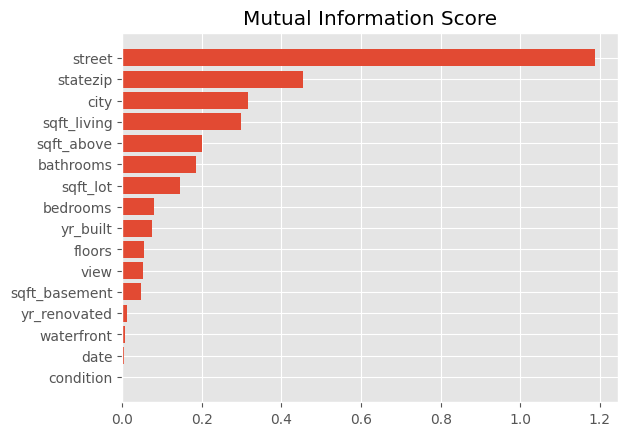

In [88]:
def plot_mi_score(score):
    score = score.sort_values(ascending = True)
    width = np.arange(len(score))
    ticks = list(score.index)
    plt.barh(width,score)
    plt.yticks(width,ticks)
    plt.title('Mutual Information Score')

plot_mi_score(mi_score)

- The 'street' feature has the highest MI score of 1.149118, indicating a strong relationship with the 'price' variable.
- The 'country' feature has a MI score of 0.000000, suggesting it has no discernible relationship with the 'price' variable based on Mutual Information.

In [89]:
df = df[['street','statezip','city','sqft_living','sqft_above','bathrooms','yr_built','sqft_lot','bedrooms']]
df = df.join(y)

#### Removing Outliers with Z-score¶
- While calculating the z-score we rescale and center the data and look for data points which are too far from zero. These data points which are way too far from zero will be trated as the outliers.
- In most of the cases a threshold of 3 or -3 is used. If the Z-score value is greater than or less than 3 or -3 respectively, that data points will be defines as outliers.

In [90]:
z = np.abs(stats.zscore(df[['sqft_living','sqft_above','bathrooms','yr_built','sqft_lot','bedrooms']]))
print(z)

      sqft_living  sqft_above  bathrooms  yr_built  sqft_lot  bedrooms
0        0.829971    0.565224   0.843204  0.531014  0.193434  0.441122
1        1.568528    1.789559   0.432802  1.674693  0.161718  1.759705
2        0.217367    0.119171   0.205201  0.161000  0.080978  0.441122
3        0.144686    0.959621   0.113800  0.261913  0.190145  0.441122
4        0.206984    0.797222   0.432802  0.175376  0.121306  0.659291
...           ...         ...        ...       ...       ...       ...
4595     0.653458    0.368025   0.524202  0.564651  0.236689  0.441122
4596     0.705374    0.426025   0.432802  0.410840  0.202882  0.441122
4597     0.904009    1.371962   0.432802  1.285418  0.218462  0.441122
4598     0.051238    0.878421   0.205201  0.108101  0.229164  0.659291
4599     0.674224    0.391225   0.432802  0.646303  0.188139  0.441122

[4600 rows x 6 columns]


In [91]:
print(np.where(z > 3))

(array([  56,  107,  122,  122,  122,  122,  122,  217,  227,  233,  240,
        241,  252,  252,  252,  254,  272,  291,  291,  375,  418,  418,
        452,  461,  462,  462,  462,  462,  471,  479,  484,  495,  548,
        575,  581,  581,  634,  634,  634,  675,  679,  743,  747,  779,
        798,  839,  847,  878,  879,  999, 1017, 1031, 1078, 1089, 1103,
       1128, 1130, 1132, 1132, 1182, 1182, 1209, 1209, 1209, 1261, 1265,
       1272, 1275, 1275, 1301, 1302, 1302, 1360, 1390, 1406, 1408, 1411,
       1417, 1417, 1424, 1455, 1479, 1500, 1539, 1567, 1567, 1571, 1602,
       1637, 1644, 1722, 1762, 1786, 1944, 1952, 1952, 1962, 1962, 2005,
       2005, 2152, 2155, 2157, 2199, 2226, 2279, 2286, 2286, 2300, 2316,
       2328, 2328, 2328, 2365, 2401, 2480, 2551, 2588, 2654, 2654, 2654,
       2717, 2725, 2731, 2731, 2731, 2731, 2761, 2761, 2846, 2846, 2855,
       2872, 2889, 2917, 2967, 2967, 2967, 2968, 2980, 2980, 3004, 3004,
       3004, 3004, 3046, 3056, 3099, 3117, 3122, 3

Let's remove the outliers and get the clean data!



In [92]:
df = df[(z < 3).all(axis=1)]
df.shape

(4435, 10)

In [93]:
df.head()

,street,statezip,city,sqft_living,sqft_above,bathrooms,yr_built,sqft_lot,bedrooms,price
0,18810 Densmore Ave N,WA 98133,Shoreline,1340,1340,1.50,1955,7912,3.0,313000.0
1,709 W Blaine St,WA 98119,Seattle,3650,3370,2.50,1921,9050,5.0,2384000.0
2,26206-26214 143rd Ave SE,WA 98042,Kent,1930,1930,2.00,1966,11947,3.0,342000.0
3,857 170th Pl NE,WA 98008,Bellevue,2000,1000,2.25,1963,8030,3.0,420000.0
4,9105 170th Ave NE,WA 98052,Redmond,1940,1140,2.50,1976,10500,4.0,550000.0


In [94]:
X = df.drop(columns=['price'])
y = df['price']


In [95]:
X.head()

,street,statezip,city,sqft_living,sqft_above,bathrooms,yr_built,sqft_lot,bedrooms
0,18810 Densmore Ave N,WA 98133,Shoreline,1340,1340,1.50,1955,7912,3.0
1,709 W Blaine St,WA 98119,Seattle,3650,3370,2.50,1921,9050,5.0
2,26206-26214 143rd Ave SE,WA 98042,Kent,1930,1930,2.00,1966,11947,3.0
3,857 170th Pl NE,WA 98008,Bellevue,2000,1000,2.25,1963,8030,3.0
4,9105 170th Ave NE,WA 98052,Redmond,1940,1140,2.50,1976,10500,4.0


In [96]:
y = pd.DataFrame(y)
y['price'] = df['price'].apply(lambda x: '{:.2f}'.format(x))
y = y.astype(float)

y.head()

,price
0,313000.0
1,2384000.0
2,342000.0
3,420000.0
4,550000.0


#### Target Encoding
We saw in our mutual information score that street, city and zipcodes do affect the pricing of house. And which makes sense from a buyer's perspective as well. Houses belong to an urban area have higher prices compare to the areas which are far from city.

So to drive this point home, we should not neglect that features. What we can do is, with the help of target encoding we will encode these features.

In [97]:
# When using encoders like MEstimateEncoder, transforming both the features (X) and the target variable (y) is necessary because these types
# of encoders rely on the relationship between the categorical features and the target variable to create the encoding.
encoder = MEstimateEncoder(cols=['street','statezip','city'], m=0.5)
X = encoder.fit_transform(X,y)

# The values of the actual (y) variable are not altered, instead they are only used to to compute the statistical means necessary for the encoding of
# categorical features in (X). The target variable (y) remains unchanged and is used in its original form for training the model after the categorical
# features have been encoded.

In [98]:
X.head()

,street,statezip,city,sqft_living,sqft_above,bathrooms,yr_built,sqft_lot,bedrooms
0,3.859344e+05,375656.132859,421503.366526,1340,1340,1.50,1955,7912,3.0
1,1.766601e+06,849969.156830,570200.891589,3650,3370,2.50,1921,9050,5.0
2,4.052677e+05,321296.502183,439062.351704,1930,1930,2.00,1966,11947,3.0
3,4.572677e+05,605283.972110,794664.954300,2000,1000,2.25,1963,8030,3.0
4,5.439344e+05,637165.488778,641698.401301,1940,1140,2.50,1976,10500,4.0


In [99]:
y.head()

,price
0,313000.0
1,2384000.0
2,342000.0
3,420000.0
4,550000.0


In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42,shuffle=False)

In [101]:
X_train.shape, X_test.shape

((3548, 9), (887, 9))

In [104]:
model = LinearRegression()
model.fit(X_train, y_train)

cvs = cross_val_score(model, X_train, y_train, cv=10, n_jobs=-1)
print(f'Training Accuracy: {cvs.mean() * 100} %')

y_pred = model.predict(X_test)


Training Accuracy: 99.65554624503532 %


In [105]:
# from xgboost import XGBRegressor
# reg = XGBRegressor()
# model = reg.fit(X_train, y_train)
# cvs = cross_val_score(model, X_train, y_train, cv=10, n_jobs=-1)
# print(f'Training Accuracy: {cvs.mean() * 100} %')

# y_pred = model.predict(X_test)

In [106]:
root_mean_squared_error(y_test,y_pred)

28086.646969970738

In [107]:
mean_absolute_error(y_test,y_pred)

4556.880761282823

In [108]:
print(f'R2-score : {r2_score(y_test,y_pred)* 100} %')

R2-score : 99.9257140633257 %


### testing some samples

In [117]:
X_test[0],y_test[0]

(array([4.10474413e+05, 3.78221239e+05, 4.21503367e+05, 9.60000000e+02,
        9.60000000e+02, 1.00000000e+00, 1.95800000e+03, 8.85500000e+03,
        3.00000000e+00]),
 array([349810.]))

In [118]:
input = np.array([4.10474413e+05, 3.78221239e+05, 4.21503367e+05, 9.60000000e+02,
        9.60000000e+02, 1.00000000e+00, 1.95800000e+03, 8.85500000e+03,
        3.00000000e+00]).reshape(1,9)
model.predict(input)

array([[348074.29495282]])

##### we can see that output of the actual and the predicted values are too closer which ensures our model is working fine.